In [1]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.optimizers import Adam
from keras.models import Sequential, Model
from keras import backend as K
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Input, Conv1D, MaxPooling1D
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import pandas as pd


from keras.layers import Input, Dense, Dropout, concatenate, LSTM, Conv2D, MaxPooling2D, Flatten, GlobalMaxPooling1D,  Embedding
from keras.models import Model
from keras.optimizers import Adam, RMSprop
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
from keras.applications.vgg16 import VGG16
from keras.utils import to_categorical
from sklearn.metrics import classification_report, confusion_matrix

In [2]:
import tensorflow as tf
tf.get_logger().setLevel('INFO')

##### Defining some important metrics

In [3]:
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

## Load the training, testing and valdiation JSONLs

In [110]:
# train_li = []
# # Open the JSONL file
# with open('./train.jsonl', 'r') as f:
#     # Read each line of the file as a separate JSON object
#     for line in f:
#         train_li.append(json.loads(line))
        
# test_li = []
# # Open the JSONL file
# with open('./test_seen.jsonl', 'r') as f:
#     # Read eactest_seen.jsonlh line of the file as a separate JSON object
#     for line in f:
#         test_li.append(json.loads(line))
        
# dev_li = []
# # Open the JSONL file
# with open('./dev_seen.jsonl', 'r') as f:
#     # Read eactest_seen.jsonlh line of the file as a separate JSON object
#     for line in f:
#         dev_li.append(json.loads(line))
        
# ## Getting dataframes
train_path = "C:/Users/Ishit/pytorch/DL_A4/data/df_train_cleaned.csv"
val_path = "C:/Users/Ishit/pytorch/DL_A4/data/df_dev_cleaned.csv"
test_path = "C:/Users/Ishit/pytorch/DL_A4/data/df_test_seen.csv"
image_path = "C:/Users/Ishit/Downloads/archive (1)/data/"

train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)
dev_df = pd.read_csv(val_path)

In [111]:
train_text = train_df['text'].tolist()
test_text = test_df['text'].tolist()
dev_text = dev_df['text'].tolist()

In [112]:
y_train = train_df['label'].tolist()
y_test = test_df['label'].tolist()
y_dev = dev_df['label'].tolist()

In [113]:
max_len = 100
tokenizer = Tokenizer()

tokenizer.fit_on_texts(train_df['text'])

sequences_train = tokenizer.texts_to_sequences(train_df['text'])
sequences_val = tokenizer.texts_to_sequences(dev_df['text'])
sequences_test = tokenizer.texts_to_sequences(test_df['text'])

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

x_train = pad_sequences(sequences_train, maxlen=max_len)
x_val = pad_sequences(sequences_val, maxlen=max_len)
x_test = pad_sequences(sequences_test, maxlen=max_len)

y_train = np.array(train_df['label'])
y_val = np.array(dev_df['label'])
y_test = np.array(test_df['label'])

Found 6452 unique tokens.


In [114]:
# # # tokenizing
# # train_text = [word_tokenize(i) for i in train_text]
# # test_text = [word_tokenize(i) for i in test_text]
# # dev_text = [word_tokenize(i) for i in dev_text]

# # # word to index
# # word2idx = { word: idx+1 for idx, word in enumerate(set([word for sentence in train_text for word in sentence]))}
# # word2idx['UNK'] = len(word2idx)
# # word2idx['PAD'] = 0

# # # padding
# # max_length = 100
# # train_text = [[word2idx[word] for word in sentence] for sentence in train_text]
# # test_text = [[word2idx[word] if word in word2idx else word2idx['UNK'] for word in sentence] for sentence in test_text]
# # dev_text = [[word2idx[word] if word in word2idx else word2idx['UNK'] for word in sentence] for sentence in dev_text]

# # train_text = pad_sequences(train_text, maxlen=max_length, padding='post')
# # test_text = pad_sequences(test_text, maxlen=max_length, padding='post')
# # dev_text = pad_sequences(dev_text, maxlen=max_length, padding='post')

# from nltk.tokenize import word_tokenize
# from tensorflow.keras.preprocessing.sequence import pad_sequences
# import re
# from collections import Counter

# # Preprocessing
# def preprocess_text(sentence):
#     # print(sentence)
#     text = sentence[0]

#     text = text.lower()
#     text = re.sub(r"[^a-zA-Z0-9\s]", "", text)
#     return text

# train_text = [preprocess_text(sentence) for sentence in train_text]
# test_text = [preprocess_text(sentence) for sentence in test_text]
# dev_text = [preprocess_text(sentence) for sentence in dev_text]

# # Tokenization
# train_text = [word_tokenize(sentence) for sentence in train_text]
# test_text = [word_tokenize(sentence) for sentence in test_text]
# dev_text = [word_tokenize(sentence) for sentence in dev_text]

# # Vocabulary Creation (Limit to Top 12,000 Words)
# word_counts = Counter(word for sentence in train_text for word in sentence)
# most_common_words = [word for word, _ in word_counts.most_common(12000)]
# word2idx = {word: idx+1 for idx, word in enumerate(most_common_words)}
# word2idx['UNK'] = len(word2idx) + 1
# word2idx['PAD'] = 0

# # Sequence Conversion
# train_text = [[word2idx.get(word, word2idx['UNK']) for word in sentence] for sentence in train_text]
# test_text = [[word2idx.get(word, word2idx['UNK']) for word in sentence] for sentence in test_text]
# dev_text = [[word2idx.get(word, word2idx['UNK']) for word in sentence] for sentence in dev_text]

# # Padding
# max_length = 100
# x_train = pad_sequences(train_text, maxlen=max_length, padding='post')
# x_test = pad_sequences(test_text, maxlen=max_length, padding='post')
# x_val = pad_sequences(dev_text, maxlen=max_length, padding='post')




### Preprocessing the text

In [115]:
# # word2idx
# word2idx = {word: idx + 1 for idx, word in enumerate(unique_words)}
# word2idx['<pad>'] = 0

# # tokenizing
# train_sequences = [[word2idx[word] for word in sent.split()] for sent in train_text]
# test_sequences = [[word2idx.get(word, 0) for word in sent.split()] for sent in test_text]
# dev_sequences = [[word2idx.get(word, 0) for word in sent.split()] for sent in dev_text]

# # padding
# MAX_SEQ_LENGTH = max([len(sent) for sent in train_sequences])
# x_train = pad_sequences(train_sequences, maxlen=MAX_SEQ_LENGTH, padding='post')
# x_test = pad_sequences(test_sequences, maxlen=MAX_SEQ_LENGTH, padding='post')
# x_val = pad_sequences(dev_sequences, maxlen=MAX_SEQ_LENGTH, padding='post')

In [116]:
# # convert y to tensor
# y_train = to_categorical(y_train)
# y_test = to_categorical(y_test)
# y_val = to_categorical(y_dev)

In [117]:
# # # Preprocess the text data
# max_len = 100
# tokenizer = Tokenizer()

# tokenizer.fit_on_texts(train_df['text'])

# sequences_train = tokenizer.texts_to_sequences(train_df['text'])
# sequences_val = tokenizer.texts_to_sequences(dev_df['text'])
# sequences_test = tokenizer.texts_to_sequences(test_df['text'])

# word_index = tokenizer.word_index
# print('Found %s unique tokens.' % len(word_index))

In [118]:
from torch.utils.data import Dataset, DataLoader
class TextClassification(Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y
        
    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

In [119]:
train_dataset = TextClassification(x_train, y_train)
val_dataset = TextClassification(x_val, y_val)
test_dataset = TextClassification(x_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

In [81]:
for x, y in train_loader:
    print(x.shape, y.shape)
    break

torch.Size([32, 100]) torch.Size([32])


In [55]:
import gensim
glove_model = gensim.models.KeyedVectors.load("glove_model")

In [56]:
# implement the model using LSTM in pytorch
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

In [57]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [94]:
class LSTM(nn.Module):
    def __init__(self, embedding_matrix, hidden_size, num_layers, num_classes):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.embedding = nn.Embedding.from_pretrained(embedding_matrix)
        self.lstm = nn.LSTM(embedding_matrix.shape[1], hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)
        
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        
        out = self.embedding(x)
        out, _ = self.lstm(out, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

In [103]:
# Hyperparameters
num_epochs = 10
learning_rate = 0.001
hidden_size = 64
num_layers = 2
num_classes = 2

model = LSTM(torch.FloatTensor(glove_model.vectors), hidden_size, num_layers, num_classes).to(device)

In [104]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [106]:
# Train the model
epochs = 10

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(epochs):
    train_loss = 0.0
    train_accuracy = 0.0

    model.train()
    for i, (data, labels) in enumerate(train_loader):
        data = data.to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = model(data)
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        train_accuracy += (predicted == labels).sum().item()
        
    # print(f'Epoch [{epoch+1}], Loss: {train_loss}, Accuracy: {train_accuracy/len(train_dataset)}')
    
    # validation
    model.eval()
    with torch.no_grad():
        val_loss = 0.0
        val_accuracy = 0.0

        for i, (data, labels) in enumerate(val_loader):
            data = data.to(device)
            labels = labels.to(device)

            outputs = model(data)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            val_accuracy += (predicted == labels).sum().item()

    # print(f'Epoch [{epoch+1}], Loss: {val_loss}, Accuracy: {val_accuracy/len(val_dataset)}')
    train_loss /= len(train_loader)
    train_accuracy /= len(train_dataset)
    val_loss /= len(val_loader)
    val_accuracy /= len(val_dataset)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_accuracy)
    val_accuracies.append(val_accuracy)

    print(f'Epoch [{epoch+1}], Train Loss: {train_loss}, Train Accuracy: {100*train_accuracy}, Val Loss: {val_loss}, Val Accuracy: {100*val_accuracy}')

Epoch [1], Train Loss: 0.5289057761658239, Train Accuracy: 73.35400763358778, Val Loss: 0.8906242623925209, Val Accuracy: 53.41365461847389
Epoch [2], Train Loss: 0.47948707310298017, Train Accuracy: 76.78912213740458, Val Loss: 0.9944566339254379, Val Accuracy: 53.01204819277109
Epoch [3], Train Loss: 0.43057350825717433, Train Accuracy: 79.55629770992367, Val Loss: 1.0721925273537636, Val Accuracy: 55.020080321285135
Epoch [4], Train Loss: 0.3870471936600809, Train Accuracy: 82.20419847328245, Val Loss: 1.2405956983566284, Val Accuracy: 52.610441767068274
Epoch [5], Train Loss: 0.3274948372868181, Train Accuracy: 85.30534351145039, Val Loss: 1.1597339659929276, Val Accuracy: 52.610441767068274
Epoch [6], Train Loss: 0.28339532194019273, Train Accuracy: 87.1421755725191, Val Loss: 1.333120971918106, Val Accuracy: 51.00401606425703
Epoch [7], Train Loss: 0.25777505912626064, Train Accuracy: 88.9074427480916, Val Loss: 1.4657319784164429, Val Accuracy: 49.39759036144578
Epoch [8], Train

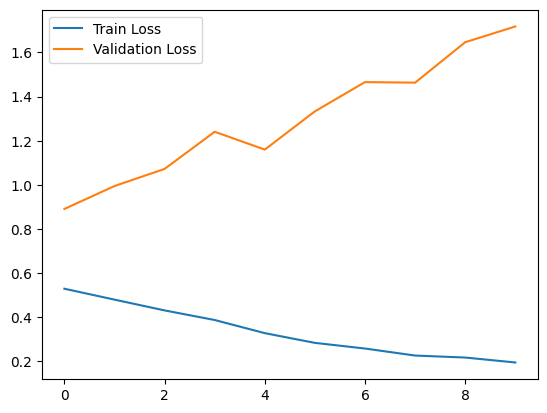

In [107]:
# plot the loss and accuracy
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.legend()

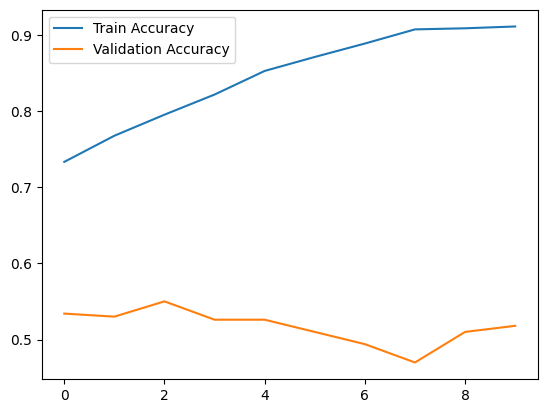

In [108]:
# plot the accuracy
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.legend()

In [120]:
# Test the model and report the accuracy, f1-score, precision and recall
model.eval()

with torch.no_grad():
    correct = 0
    total = 0
    y_true = []
    y_pred = []

    for i, (data, labels) in enumerate(test_loader):
        data = data.to(device)
        labels = labels.to(device)

        outputs = model(data)
        _, predicted = torch.max(outputs, 1)

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print(f'Accuracy: {100*correct/total}')
    print(classification_report(y_true, y_pred))



Accuracy: 54.84581497797357
              precision    recall  f1-score   support

           0       0.52      0.87      0.65       221
           1       0.66      0.24      0.36       233

    accuracy                           0.55       454
   macro avg       0.59      0.56      0.50       454
weighted avg       0.59      0.55      0.50       454

